## Result Parsing

All variants as follow:
1. Base-HNeRV: Default HNeRV (8bit, 960x480, quant 8_6, huffman)
2. Quant-HNeRV: Default HNeRV but with (QTM 32, 960x480, quant_32_6, huffman) 
2. Bare-2x-HNeRV: 2x HNeRV (1920x960; no quant) (maybe skip)
3. Quant-2x-HNeRV: 2x HNeRV (with quant)
4. Huffman-2x-HNeRV: 2x HNeRV with Huffman
5. Brotli-2x-HNeRV or HNeRV-XS: 2x HNeRV with Brotli

From the above, 1,2, 5 and 6 are available already. We just need to compute for 3 and 4, which should be quickly doable with the trained weights.

Note that for the BPP values for 2x model, will need to manually further divide by super_rate ** 2 to account for super-res's extra pixels.

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
#Get all results
base = '/scratch/kl3866/IVP/HNeRV/batches/final/8bit_HNeRV_gamut/8bit_HNeRV_gamut'
quant = '/scratch/kl3866/IVP/HNeRV/batches/final/vanilla_HNeRV_gamut'
full_2x = '/scratch/kl3866/IVP/HNeRV/batches/final/2x_1080_HNeRV_gamut/2x_HNeRV_gamut'
brotli = '/scratch/kl3866/IVP/HNeRV/batches/final/2x_1080_HNeRV_gamut/brotli'

In [3]:
bit16 = '/scratch/kl3866/IVP/HNeRV/batches/output/2x_16bit_gamut/'
bit24 = '/scratch/kl3866/IVP/HNeRV/batches/output/2x_24bit_gamut/'
bit8 = '/scratch/kl3866/IVP/HNeRV/batches/output/2x_8bit_gamut/'

In [4]:
#Precomputed n-frames per seq
ct ={'Twilight': 600,
     'SunBath': 300,
     'Bosphorus': 600,
     'RaceNight': 600,
     'FlowerKids': 600,
     'Beauty': 600,
     'CityAlley': 600,
     'ReadySteadyGo': 600,
     'FlowerFocus': 600,
     'Jockey': 600,
     'YatchRide': 600,
     'HoneyBee': 600,
     'ShakeNDry': 300,
     'RiverBank': 600}

In [5]:
fps = {'Twilight': 50,
     'SunBath': 50,
     'Bosphorus': 120,
     'RaceNight': 50,
     'FlowerKids': 50,
     'Beauty': 120,
     'CityAlley': 50,
     'ReadySteadyGo': 120,
     'FlowerFocus': 50,
     'Jockey': 120,
     'YatchRide': 120,
     'HoneyBee': 120,
     'ShakeNDry': 120,
     'RiverBank': 50}

In [6]:
#Helper
# Define function to calculate MSE
def mse(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return mse

### For Model 1:  Base-HNeRV

In [9]:
#Read 
f1 = [os.path.join(base,i) for i in os.listdir(base) if 'zip' not in i and '8bit' in i]
f1 = [os.path.join(i,j,'epoch300.csv') for i in f1 for j in os.listdir(i)]

In [10]:
f1_ = [pd.read_csv(i,index_col=0) for i in f1]
f1_ = pd.concat(f1_)

In [11]:
f1_

,Vid,CurEpoch,Train Time,Compression Method,Compression Encoding Time,Compression Decoding Time,"FPS (Quantized, Full Pass)","FPS (Quantized, Forward Pass)","FPS (Full Model, Full Pass)","FPS (Full Model, Forward Pass)",...,best_pred_unseen_psnr,best_pred_unseen_ssim,best_quant_seen_psnr,best_quant_seen_ssim,best_quant_unseen_psnr,best_quant_unseen_ssim,pred_seen_psnr,pred_seen_ssim,pred_unseen_psnr,pred_unseen_ssim
0,8bit_SunBath_QTM8_QTE6,300,0:50:24.003284,huffman,0.064420,2.353251,133.015832,143.921128,138.174455,149.997979,...,0.0,0.0,31.59,0.9594,0.0,0.0,31.82,0.9606,0.0,0.0
0,8bit_RaceNight_QTM8_QTE6,300,1:35:47.762559,huffman,0.066487,2.540431,137.826021,149.168607,142.219819,154.216404,...,0.0,0.0,27.17,0.9096,0.0,0.0,27.33,0.9111,0.0,0.0
0,8bit_FlowerKids_QTM8_QTE6,300,1:34:36.906566,huffman,0.067015,2.554111,135.742138,146.995554,141.643647,153.893585,...,0.0,0.0,27.41,0.9073,0.0,0.0,27.51,0.9085,0.0,0.0
0,8bit_FlowerFocus_QTM8_QTE6,300,1:36:04.753925,huffman,0.066612,2.540139,135.829924,146.988367,141.094730,153.042782,...,0.0,0.0,38.46,0.9780,0.0,0.0,38.59,0.9783,0.0,0.0
0,8bit_RiverBank_QTM8_QTE6,300,1:34:32.885050,huffman,0.066896,2.538213,136.135327,147.538088,141.225289,153.503039,...,0.0,0.0,31.09,0.9542,0.0,0.0,31.15,0.9547,0.0,0.0
0,8bit_CityAlley_QTM8_QTE6,300,1:01:03.376778,huffman,0.067002,2.530274,134.408990,145.741463,140.045503,152.381663,...,0.0,0.0,40.98,0.9937,0.0,0.0,41.09,0.9938,0.0,0.0
0,8bit_YatchRide_QTM8_QTE6,300,1:15:14.024658,huffman,0.058714,2.341108,137.376396,149.085354,142.329943,154.956016,...,0.0,0.0,28.73,0.9183,0.0,0.0,28.81,0.9193,0.0,0.0
0,8bit_ShakeNDry_QTM8_QTE6,300,0:48:55.996256,huffman,0.068516,2.578732,133.338278,144.212773,139.192675,151.044523,...,0.0,0.0,34.83,0.9667,0.0,0.0,34.89,0.9668,0.0,0.0
0,8bit_Jockey_QTM8_QTE6,300,0:46:40.587834,huffman,0.070482,2.533766,136.177832,147.641983,141.641048,153.912089,...,0.0,0.0,30.53,0.8878,0.0,0.0,30.67,0.8891,0.0,0.0
0,8bit_Bosphorus_QTM8_QTE6,300,1:42:16.368930,huffman,0.067261,2.376842,135.235957,147.038574,141.089486,153.990936,...,0.0,0.0,33.97,0.9602,0.0,0.0,34.05,0.9607,0.0,0.0


In [8]:
#Compute BPS
w,h = f1_['Crop'].str.split("_").iloc[0]
pc = float(w) * float(h)

bps = []

for k,v in f1_.iterrows():
    vid = v['Vid'].split('_')[1]
    w,h = v['Crop'].split("_")
    pc = float(w) * float(h) #pixel count per frame; ignore channel
    nframe = ct[vid]
    fp = fps[vid]
    
    bps_ = round(float(v['bits/pixel']) * pc * fp,4)
    bps.append(bps_)
    
f1_['BPS'] = bps

In [9]:
#Read images (ori)
f1_psnrs_ori= []

for ifx,f in enumerate(f1):
    img_ori_ = os.path.join('/'.join(f.split('/')[:-1]), 'visualize_model_orig')
    img_ori = [cv2.imread(os.path.join(img_ori_,i)).astype(float) for i in os.listdir(img_ori_)]

    #Break into pred vs gt
    h,w,_ = img_ori[0].shape
    
    gt = [i[:,:(w//2),:] for i in img_ori]
    pred = [i[:,(w//2):,:] for i in img_ori]
    
    assert gt[0].max() <= 255, "Error! Max val >255"
    
    #Compute PSNR
    mses = [mse(i,j) for i,j in zip(gt,pred)]
    psnr = 10 * np.log10(255**2 / np.mean(mses))
    
    #Log
    f1_psnrs_ori.append(psnr)
    
    print("{}/{}...".format(ifx+1,len(f1)))

1/14...
2/14...
3/14...
4/14...
5/14...
6/14...
7/14...
8/14...
9/14...
10/14...
11/14...
12/14...
13/14...
14/14...


In [10]:
#Read images (quant)
f1_psnrs_quant= []

for ifx,f in enumerate(f1):
    img_quant_ = os.path.join('/'.join(f.split('/')[:-1]), 'visualize_model_quant')
    img_quant = [cv2.imread(os.path.join(img_quant_,i)).astype(float) for i in os.listdir(img_quant_)]

    #Break into pred vs gt
    h,w,_ = img_quant[0].shape
    
    gt = [i[:,:(w//2),:] for i in img_quant]
    pred = [i[:,(w//2):,:] for i in img_quant]
    
    assert gt[0].max() <= 255, "Error! Max val >255"
    
    #Compute PSNR
    mses = [mse(i,j) for i,j in zip(gt,pred)]
    psnr = 10 * np.log10(255**2 / np.mean(mses))
    
    #Log
    f1_psnrs_quant.append(psnr)
    
    print("{}/{}...".format(ifx+1,len(f1)))

1/14...
2/14...
3/14...
4/14...
5/14...
6/14...
7/14...
8/14...
9/14...
10/14...
11/14...
12/14...
13/14...
14/14...


In [11]:
#Store
f1_['Evaluation Quant Overall PSNR'] = f1_psnrs_quant
f1_['Evaluation Orig Overall PSNR'] = f1_psnrs_ori

In [8]:
f1_

NameError: name 'f1_' is not defined

In [13]:
#Look at overall PSNR
f1_psnr_quant_avg = np.mean(f1_psnrs_quant)
f1_psnr_ori_avg = np.mean(f1_psnrs_ori)

f1_bpp_avg = f1_['bits/pixel'].mean()

print("[PSNR] >> Quant: {} | Ori: {}".format(f1_psnr_quant_avg,f1_psnr_ori_avg))
print("[BPP]: Avg: {}".format(f1_bpp_avg))

[PSNR] >> Quant: 33.068937310186065 | Ori: 33.178492848783385
[BPP]: Avg: 0.04938486018105153


In [14]:
#Save
f1_.to_csv('results/f1.csv')

### For Model 2:  Quant-HNeRV

In [13]:
#Read 
f2 = [os.path.join(quant,i) for i in os.listdir(quant)]
f2 = [os.path.join(i,j,'epoch300.csv') for i in f2 for j in os.listdir(i)]

In [14]:
f2_ = [pd.read_csv(i,index_col=0) for i in f2]
f2_ = pd.concat(f2_)

In [15]:
#Clean cols
f2_['Evaluation Orig Overall PSNR'] = f2_['Evaluation Orig Overall PSNR'].str[7:-1].astype(float)
f2_['Evaluation Quant Overall PSNR'] = f2_['Evaluation Quant Overall PSNR'].str[7:-1].astype(float)

In [44]:
f2_

,Vid,CurEpoch,Train Time,Compression Method,Compression Encoding Time,Compression Decoding Time,"FPS (Quantized, Full Pass)","FPS (Quantized, Forward Pass)","FPS (Full Model, Full Pass)","FPS (Full Model, Forward Pass)",...,best_pred_unseen_psnr,best_pred_unseen_ssim,best_quant_seen_psnr,best_quant_seen_ssim,best_quant_unseen_psnr,best_quant_unseen_ssim,pred_seen_psnr,pred_seen_ssim,pred_unseen_psnr,pred_unseen_ssim
0,vanilla_HoneyBee_QTM{qt_model}_QTE6,300,1:27:03.324115,huffman,0.059623,0.606808,73.510800,79.439025,71.568192,77.170980,...,0.0,0.0,29.26,0.9294,0.0,0.0,29.00,0.9291,0.0,0.0
0,vanilla_Jockey_QTM{qt_model}_QTE6,300,1:28:06.073025,huffman,0.060709,0.675008,73.416076,79.419446,71.729445,77.359535,...,0.0,0.0,30.51,0.8880,0.0,0.0,30.63,0.8890,0.0,0.0
0,vanilla_FlowerKids_QTM{qt_model}_QTE6,300,1:26:02.485607,huffman,0.063071,0.733914,73.411823,79.350961,72.421438,78.184312,...,0.0,0.0,27.37,0.9068,0.0,0.0,27.44,0.9078,0.0,0.0
0,vanilla_ShakeNDry_QTM{qt_model}_QTE6,300,0:45:00.650280,huffman,0.062158,0.661760,72.264420,78.013137,71.248868,76.829364,...,0.0,0.0,34.78,0.9655,0.0,0.0,34.80,0.9656,0.0,0.0
0,vanilla_ReadySteadyGo_QTM{qt_model}_QTE6,300,1:27:28.805959,huffman,0.063894,0.716866,73.769356,79.814533,72.408631,78.221163,...,0.0,0.0,24.25,0.8697,0.0,0.0,24.34,0.8713,0.0,0.0
0,vanilla_RaceNight_QTM{qt_model}_QTE6,300,1:28:02.480504,huffman,0.058759,0.675569,73.176265,79.050667,71.354369,76.929607,...,0.0,0.0,27.03,0.9078,0.0,0.0,27.15,0.9091,0.0,0.0
0,vanilla_Twilight_QTM{qt_model}_QTE6,300,1:25:41.858069,huffman,0.062950,0.723135,73.639851,79.541919,71.927105,77.535862,...,0.0,0.0,40.98,0.9897,0.0,0.0,41.03,0.9897,0.0,0.0
0,vanilla_RiverBank_QTM{qt_model}_QTE6,300,1:25:22.792418,huffman,0.063020,0.645152,73.733386,79.756976,72.708769,78.561467,...,0.0,0.0,20.69,0.7008,0.0,0.0,20.69,0.7008,0.0,0.0
0,vanilla_CityAlley_QTM{qt_model}_QTE6,300,1:26:46.919438,huffman,0.066104,0.772670,72.679514,78.504703,72.222830,77.964736,...,0.0,0.0,41.21,0.9935,0.0,0.0,41.28,0.9936,0.0,0.0
0,vanilla_YatchRide_QTM{qt_model}_QTE6,300,1:25:39.744668,huffman,0.061953,0.716018,73.301077,79.136866,71.695927,77.260303,...,0.0,0.0,28.69,0.9180,0.0,0.0,28.74,0.9186,0.0,0.0


In [18]:
#Compute BPS
w,h = f2_['Crop'].str.split("_").iloc[0]
pc = float(w) * float(h)

bps = []

for k,v in f2_.iterrows():
    vid = v['Vid'].split('_')[1]
    w,h = v['Crop'].split("_")
    pc = float(w) * float(h) #pixel count per frame; ignore channel
    nframe = ct[vid]
    fp = fps[vid]
    
    bps_ = round(float(v['bits/pixel']) * pc * fp,4)
    bps.append(bps_)
    
f2_['BPS'] = bps

In [19]:
#Look at overall PSNR
f2_psnr_ori_avg = np.mean(f2_['Evaluation Orig Overall PSNR'])
f2_psnr_quant_avg = np.mean(f2_['Evaluation Quant Overall PSNR'])

f2_bpp_avg = f2_['bits/pixel'].mean()

print("[PSNR] >> Quant: {} | Ori: {}".format(f2_psnr_quant_avg,f2_psnr_ori_avg))
print("[BPP]: Avg: {}".format(f2_bpp_avg))

[PSNR] >> Quant: 31.41642857142858 | Ori: 31.348571428571425
[BPP]: Avg: 0.008421386202050215


In [20]:
#Save
f2_.to_csv('results/f2.csv')

### For Model 3 (SKIP)

In [19]:
#Read 
f3 = [os.path.join(full_2x,i) for i in os.listdir(full_2x) if 'test' not in i and 'zip' not in i]
f3 = [os.path.join(i,j,'epoch600.csv') for i in f3 for j in os.listdir(i)]

In [20]:
f3_ = [pd.read_csv(i,index_col=0) for i in f3]
f3_ = pd.concat(f3_)

In [21]:
f3_

,Vid,CurEpoch,Train Time,Compression Method,Compression Encoding Time,Compression Decoding Time,"FPS (Quantized, Full Pass)","FPS (Quantized, Forward Pass)","FPS (Full Model, Full Pass)","FPS (Full Model, Forward Pass)",...,best_pred_unseen_psnr,best_pred_unseen_ssim,best_quant_seen_psnr,best_quant_seen_ssim,best_quant_unseen_psnr,best_quant_unseen_ssim,pred_seen_psnr,pred_seen_ssim,pred_unseen_psnr,pred_unseen_ssim
0,2x_Twilight_QTM32_QTE6,600,7:02:00.733412,huffman,0.066549,0.684763,64.585828,76.383212,65.798297,78.090270,...,0.0,0.0,37.67,0.9758,0.0,0.0,37.69,0.9759,0.0,0.0
0,2x_SunBath_QTM32_QTE6,600,3:33:56.519167,huffman,0.062623,0.658185,64.865925,76.750775,66.200609,78.617983,...,0.0,0.0,31.66,0.9420,0.0,0.0,31.80,0.9429,0.0,0.0
0,2x_Bosphorus_QTM32_QTE6,600,7:02:48.721272,huffman,0.062686,0.635391,64.827202,76.671286,65.884402,78.175670,...,0.0,0.0,33.15,0.9299,0.0,0.0,33.19,0.9304,0.0,0.0
0,2x_RaceNight_QTM32_QTE6,600,6:59:21.954014,huffman,0.062612,0.643195,64.881959,76.756335,66.164501,78.562340,...,0.0,0.0,26.71,0.8660,0.0,0.0,26.84,0.8676,0.0,0.0
0,2x_FlowerKids_QTM32_QTE6,600,7:03:43.157742,huffman,0.064097,0.646230,64.972279,76.910912,66.362568,78.872210,...,0.0,0.0,26.91,0.8614,0.0,0.0,26.96,0.8622,0.0,0.0
0,2x_Beauty_QTM32_QTE6,600,6:58:33.950881,huffman,0.063758,0.652844,64.897789,76.808638,66.183605,78.612811,...,0.0,0.0,32.45,0.8867,0.0,0.0,32.47,0.8870,0.0,0.0
0,2x_CityAlley_QTM32_QTE6,600,6:02:33.577684,huffman,0.065890,0.651282,65.007791,76.926433,66.244495,78.670481,...,0.0,0.0,36.79,0.9786,0.0,0.0,36.81,0.9787,0.0,0.0
0,2x_ReadySteadyGo_QTM32_QTE6,600,7:08:25.188475,huffman,0.062787,0.639482,65.072930,77.039210,66.253086,78.711470,...,0.0,0.0,24.03,0.8057,0.0,0.0,24.12,0.8074,0.0,0.0
0,2x_FlowerFocus_QTM32_QTE6,600,7:09:04.546215,huffman,0.064157,0.643068,65.021635,76.934516,66.249205,78.654600,...,0.0,0.0,37.13,0.9572,0.0,0.0,37.18,0.9574,0.0,0.0
0,2x_Jockey_QTM32_QTE6,600,6:14:23.845009,huffman,0.063332,0.632566,64.882816,76.778437,66.149655,78.562291,...,0.0,0.0,30.26,0.8629,0.0,0.0,30.38,0.8641,0.0,0.0


In [22]:
#Read images (ori)
f3_psnrs_ori= []

for ifx,f in enumerate(f3):
    img_ori_ = os.path.join('/'.join(f.split('/')[:-1]), 'visualize_model_orig')
    img_ori = [cv2.imread(os.path.join(img_ori_,i)) for i in os.listdir(img_ori_)[:2]]

    #Break into pred vs gt
    h,w,_ = img_ori[0].shape
    
    gt = [i[:,:(w//2),:] for i in img_ori]
    pred = [i[:,(w//2):,:] for i in img_ori]
    
    assert gt[0].max() <= 255, "Error! Max val >255"
    
    #Compute PSNR
    mses = [mse(i,j) for i,j in zip(gt,pred)]
    psnr = 10 * np.log10(255**2 / np.mean(mses))
    
    #Log
    f3_psnrs_ori.append(psnr)
    
    print("{}/{}...".format(ifx+1,len(f3)))

1/14...
2/14...
3/14...
4/14...
5/14...
6/14...
7/14...
8/14...
9/14...
10/14...
11/14...
12/14...
13/14...
14/14...


In [23]:
#Read images (quant)
f3_psnrs_quant= []

for ifx,f in enumerate(f3):
    img_quant_ = os.path.join('/'.join(f.split('/')[:-1]), 'visualize_model_quant')
    img_quant = [cv2.imread(os.path.join(img_quant_,i)) for i in os.listdir(img_quant_)[:2]]

    #Break into pred vs gt
    h,w,_ = img_quant[0].shape
    
    gt = [i[:,:(w//2),:] for i in img_quant]
    pred = [i[:,(w//2):,:] for i in img_quant]
    
    assert gt[0].max() <= 255, "Error! Max val >255"
    
    #Compute PSNR
    mses = [mse(i,j) for i,j in zip(gt,pred)]
    psnr = 10 * np.log10(255**2 / np.mean(mses))
    
    #Log
    f3_psnrs_quant.append(psnr)
    
    print("{}/{}...".format(ifx+1,len(f3)))

1/14...
2/14...
3/14...
4/14...
5/14...
6/14...
7/14...
8/14...
9/14...
10/14...
11/14...
12/14...
13/14...
14/14...


In [25]:
#Store
f3_['Evaluation Quant Overall PSNR'] = f3_psnrs_quant
f3_['Evaluation Orig Overall PSNR'] = f3_psnrs_ori

amend BPP; no huffman; / 4

### For Model 4: Quant-2x-HNeRV (Skip)

### For Model 5: Huffman-2x-HNeRV

In [130]:
#Read 
f5 = [os.path.join(full_2x,i) for i in os.listdir(full_2x) if 'test' not in i and 'zip' not in i]
f5 = [os.path.join(i,j,'epoch600.csv') for i in f5 for j in os.listdir(i)]

In [131]:
f5_ = [pd.read_csv(i,index_col=0) for i in f5]
f5_ = pd.concat(f5_)

In [132]:
f5_

,Vid,CurEpoch,Train Time,Compression Method,Compression Encoding Time,Compression Decoding Time,"FPS (Quantized, Full Pass)","FPS (Quantized, Forward Pass)","FPS (Full Model, Full Pass)","FPS (Full Model, Forward Pass)",...,best_pred_unseen_psnr,best_pred_unseen_ssim,best_quant_seen_psnr,best_quant_seen_ssim,best_quant_unseen_psnr,best_quant_unseen_ssim,pred_seen_psnr,pred_seen_ssim,pred_unseen_psnr,pred_unseen_ssim
0,2x_Twilight_QTM32_QTE6,600,7:02:00.733412,huffman,0.066549,0.684763,64.585828,76.383212,65.798297,78.090270,...,0.0,0.0,37.67,0.9758,0.0,0.0,37.69,0.9759,0.0,0.0
0,2x_SunBath_QTM32_QTE6,600,3:33:56.519167,huffman,0.062623,0.658185,64.865925,76.750775,66.200609,78.617983,...,0.0,0.0,31.66,0.9420,0.0,0.0,31.80,0.9429,0.0,0.0
0,2x_Bosphorus_QTM32_QTE6,600,7:02:48.721272,huffman,0.062686,0.635391,64.827202,76.671286,65.884402,78.175670,...,0.0,0.0,33.15,0.9299,0.0,0.0,33.19,0.9304,0.0,0.0
0,2x_RaceNight_QTM32_QTE6,600,6:59:21.954014,huffman,0.062612,0.643195,64.881959,76.756335,66.164501,78.562340,...,0.0,0.0,26.71,0.8660,0.0,0.0,26.84,0.8676,0.0,0.0
0,2x_FlowerKids_QTM32_QTE6,600,7:03:43.157742,huffman,0.064097,0.646230,64.972279,76.910912,66.362568,78.872210,...,0.0,0.0,26.91,0.8614,0.0,0.0,26.96,0.8622,0.0,0.0
0,2x_Beauty_QTM32_QTE6,600,6:58:33.950881,huffman,0.063758,0.652844,64.897789,76.808638,66.183605,78.612811,...,0.0,0.0,32.45,0.8867,0.0,0.0,32.47,0.8870,0.0,0.0
0,2x_CityAlley_QTM32_QTE6,600,6:02:33.577684,huffman,0.065890,0.651282,65.007791,76.926433,66.244495,78.670481,...,0.0,0.0,36.79,0.9786,0.0,0.0,36.81,0.9787,0.0,0.0
0,2x_ReadySteadyGo_QTM32_QTE6,600,7:08:25.188475,huffman,0.062787,0.639482,65.072930,77.039210,66.253086,78.711470,...,0.0,0.0,24.03,0.8057,0.0,0.0,24.12,0.8074,0.0,0.0
0,2x_FlowerFocus_QTM32_QTE6,600,7:09:04.546215,huffman,0.064157,0.643068,65.021635,76.934516,66.249205,78.654600,...,0.0,0.0,37.13,0.9572,0.0,0.0,37.18,0.9574,0.0,0.0
0,2x_Jockey_QTM32_QTE6,600,6:14:23.845009,huffman,0.063332,0.632566,64.882816,76.778437,66.149655,78.562291,...,0.0,0.0,30.26,0.8629,0.0,0.0,30.38,0.8641,0.0,0.0


In [136]:
#Read images (ori)
f5_psnrs_ori= []

for ifx,f in enumerate(f5):
    img_ori_ = os.path.join('/'.join(f.split('/')[:-1]), 'visualize_model_orig')
    img_ori = [cv2.imread(os.path.join(img_ori_,i)) for i in os.listdir(img_ori_)]

    #Break into pred vs gt
    h,w,_ = img_ori[0].shape
    
    gt = [i[:,:(w//2),:] for i in img_ori]
    pred = [i[:,(w//2):,:] for i in img_ori]
    
    assert gt[0].max() <= 255, "Error! Max val >255"
    
    #Compute PSNR
    mses = [mse(i.astype(float),j.astype(float)) for i,j in zip(gt,pred)]
    psnr = 10 * np.log10(255.0**2 / np.mean(mses))
    
    #Log
    f5_psnrs_ori.append(psnr)
    
    print("{}/{}...".format(ifx+1,len(f5)))

In [ ]:
#Read images (quant)
f5_psnrs_quant= []

for ifx,f in enumerate(f5):
    img_quant_ = os.path.join('/'.join(f.split('/')[:-1]), 'visualize_model_quant')
    img_quant = [cv2.imread(os.path.join(img_quant_,i)) for i in os.listdir(img_quant_)]

    #Break into pred vs gt
    h,w,_ = img_quant[0].shape
    
    gt = [i[:,:(w//2),:] for i in img_quant]
    pred = [i[:,(w//2):,:] for i in img_quant]
    
    assert gt[0].max() <= 255, "Error! Max val >255"
    
    #Compute PSNR
    mses = [mse(i.astype(float),j.astype(float)) for i,j in zip(gt,pred)]
    psnr = 10 * np.log10(255**2 / np.mean(mses))
    
    #Log
    f5_psnrs_quant.append(psnr)
    
    print("{}/{}...".format(ifx+1,len(f5)))

1/14...
2/14...
3/14...
4/14...
5/14...
6/14...


In [ ]:
#Store
f5_['Evaluation Quant Overall PSNR'] = f5_psnrs_quant
f5_['Evaluation Orig Overall PSNR'] = f5_psnrs_ori

In [ ]:
#Compensate BPP
f5_['bits/pixel'] = f5_['bits/pixel'] / 4 #2*2 from super_rate compensation

In [ ]:
#Compute BPS
w,h = f5_['Crop'].str.split("_").iloc[0]
pc = float(w) * float(h)

bps = []

for k,v in f5_.iterrows():
    vid = v['Vid'].split('_')[1]
    w,h = v['Crop'].split("_")
    pc = float(w) * float(h) #pixel count per frame; ignore channel
    nframe = ct[vid]
    fp = fps[vid]
    
    bps_ = round(float(v['bits/pixel']) * pc * fp,4)
    bps.append(bps_)
    
f5_['BPS'] = bps

In [ ]:
#Look at overall PSNR
f5_psnr_ori_avg = np.mean(f5_['Evaluation Orig Overall PSNR'])
f5_psnr_quant_avg = np.mean(f5_['Evaluation Quant Overall PSNR'])

f5_bpp_avg = f5_['bits/pixel'].mean()

print("[PSNR] >> Quant: {} | Ori: {}".format(f5_psnr_quant_avg,f5_psnr_ori_avg))
print("[BPP]: Avg: {}".format(f5_bpp_avg))

In [ ]:
#Save
f5_.to_csv('results/f5.csv')

### For Model 6:  Brotli-2x-HNeRV or HNeRV-XS

In [ ]:
f6_ = f5_.copy() #just use stat from model5 since they're the same, just different BPP

In [ ]:
f6_BPP = pd.read_csv('/scratch/kl3866/IVP/HNeRV/results/HNeRV_2x_1920x960_brotli_BPP.csv',index_col=0)

In [ ]:
f6_names = f6_['Vid'].values
f6_names = [i.split('_')[1] for i in f6_names]
f6_names #good order is the same as f6_BPP; makes life easier

In [ ]:
f6_BPP #check if match

In [ ]:
bpps = f6_BPP['bpp'].values
f6_['bits/pixel'] = bpps 
#super-res rate already compensated from model 5's value

In [ ]:
#Compute BPS
w,h = f6_['Crop'].str.split("_").iloc[0]
pc = float(w) * float(h)

bps = []

for k,v in f6_.iterrows():
    vid = v['Vid'].split('_')[1]
    w,h = v['Crop'].split("_")
    pc = float(w) * float(h) #pixel count per frame; ignore channel
    nframe = ct[vid]
    fp = fps[vid]
    
    bps_ = round(float(v['bits/pixel']) * pc * fp,4)
    bps.append(bps_)
    
f6_['BPS'] = bps

In [ ]:
#Look at overall PSNR
f6_psnr_ori_avg = np.mean(f6_['Evaluation Orig Overall PSNR'])
f6_psnr_quant_avg = np.mean(f6_['Evaluation Quant Overall PSNR'])

f6_bpp_avg = f6_['bits/pixel'].mean()

print("[PSNR] >> Quant: {} | Ori: {}".format(f6_psnr_quant_avg,f6_psnr_ori_avg))
print("[BPP]: Avg: {}".format(f6_bpp_avg))

In [ ]:
#Save
f6_.to_csv('results/f6.csv')

____
### Final Stats

In [6]:
#Read
f1 = pd.read_csv('results/f1.csv')
f2 = pd.read_csv('results/f2.csv')
f5 = pd.read_csv('results/f5.csv')
f6 = pd.read_csv('results/f6.csv')
hevc = pd.read_csv('results/hevc.csv')

In [7]:
#Take relevant cols only
f1_ = f1[['Vid','Crop','Epoch','bits/pixel','BPS','Evaluation Quant Overall PSNR','Evaluation Orig Overall PSNR']]
f1_.columns = [['Vid','Resolution','Train Epoch','BPP','BPS','Quant PSNR','Ori PSNR']]
f1_['Model'] = 'Vanilla 8bit'

f2_ = f2[['Vid','Crop','Epoch','bits/pixel','BPS','Evaluation Quant Overall PSNR','Evaluation Orig Overall PSNR']]
f2_.columns = [['Vid','Resolution','Train Epoch','BPP','BPS','Quant PSNR','Ori PSNR']]
f2_['Model'] = 'Vanilla 32bit'

f5_ = f5[['Vid','Crop','Epoch','bits/pixel','BPS','Evaluation Quant Overall PSNR','Evaluation Orig Overall PSNR']]
f5_.columns = [['Vid','Resolution','Train Epoch','BPP','BPS','Quant PSNR','Ori PSNR']]
f5_['Model'] = '2x 32bit'

f6_ = f6[['Vid','Crop','Epoch','bits/pixel','BPS','Evaluation Quant Overall PSNR','Evaluation Orig Overall PSNR']]
f6_.columns = [['Vid','Resolution','Train Epoch','BPP','BPS','Quant PSNR','Ori PSNR']]
f6_['Model'] = 'Broccoli'

/state/partition1/job-33212441/ipykernel_2144456/872183919.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1_['Model'] = 'Vanilla 8bit'
/state/partition1/job-33212441/ipykernel_2144456/872183919.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f2_['Model'] = 'Vanilla 32bit'
/state/partition1/job-33212441/ipykernel_2144456/872183919.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [8]:
#Combine
df1 = pd.concat([f1_,f2_,f5_,f6_],axis=0)

In [9]:
df1.tail()

,Vid,Resolution,Train Epoch,BPP,BPS,Quant PSNR,Ori PSNR,Model
9,2x_Jockey_QTM32_QTE6,960_1920,600,0.000464,102678.4,30.020039,30.143875,Broccoli
10,2x_YatchRide_QTM32_QTE6,960_1920,600,0.000614,135913.6,27.869008,27.910824,Broccoli
11,2x_HoneyBee_QTM32_QTE6,960_1920,600,0.000763,168707.2,37.845171,37.861546,Broccoli
12,2x_ShakeNDry_QTM32_QTE6,960_1920,600,0.001493,330320.0,33.239051,33.246106,Broccoli
13,2x_RiverBank_QTM32_QTE6,960_1920,600,0.000631,58168.0,27.478927,27.499972,Broccoli


In [10]:
#For HEVC
df2_960_agg = hevc.loc[hevc.Resolution=='960x540'].groupby(['QP']).mean()
df2_1080_agg = hevc.loc[hevc.Resolution=='1920x1080'].groupby(['QP']).mean()

In [11]:
#Read saved out to bypass pesky groupby issue
df1 = pd.read_csv('results/aggregated.csv',index_col=0)

In [12]:
df1_agg = df1.groupby('Model').mean()

In [18]:
df1_agg

,Train Epoch,BPP,BPS,Quant PSNR,Ori PSNR
Model,,,,,
2x 32bit,600.0,0.001802,2.812148e+05,31.594854,31.651691
Broccoli,600.0,0.000809,1.228457e+05,31.594854,31.651691
Vanilla 32bit,300.0,0.008421,3.281193e+05,31.416429,31.348571
Vanilla 8bit,300.0,0.049385,1.934169e+06,33.068937,33.178493


In [66]:
df2_1080_agg

,PSNR,BPP
QP,,
17,40.339535,0.431642
22,38.626199,0.151550
27,36.824919,0.061121
32,34.789130,0.029457
37,32.607298,0.014458
42,30.282018,0.006710


In [67]:
df2_960_agg

,PSNR,BPP
QP,,
17,39.917487,0.397785
22,37.889087,0.187117
27,35.673015,0.093010
32,33.298238,0.044746
37,30.920052,0.021217
42,28.518545,0.009769


Text(0, 0.5, 'PSNR')

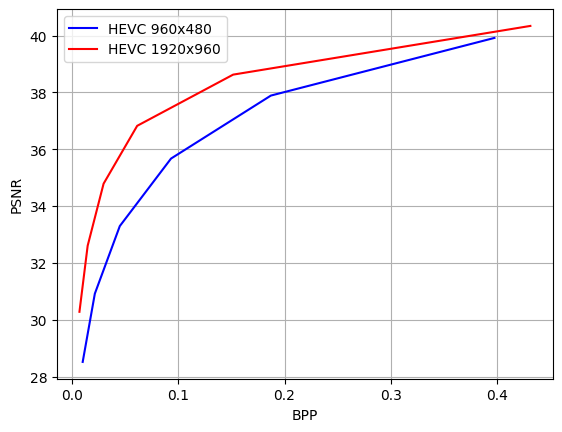

In [17]:
#Plot
plt.plot(df2_960_agg['BPP'],df2_960_agg['PSNR'],c='blue',label='HEVC 960x480')
plt.plot(df2_1080_agg['BPP'],df2_1080_agg['PSNR'],c='red',label='HEVC 1920x960')
plt.legend()
plt.grid(True)
plt.xlabel("BPP")
plt.ylabel("PSNR")

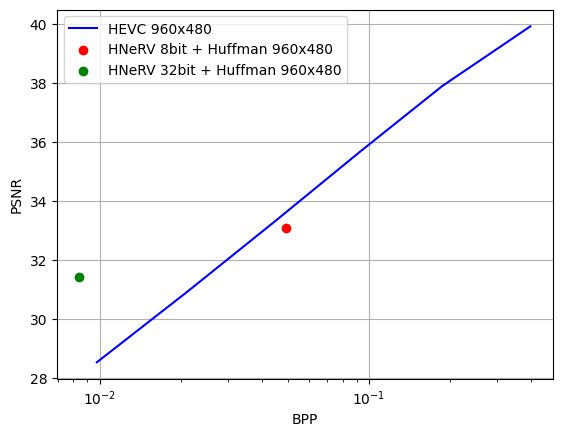

In [194]:
#Plot
plt.plot(df2_960_agg['BPP'],df2_960_agg['PSNR'],c='blue',label='HEVC 960x480')
plt.scatter(df1_agg.loc[df1_agg.index=='Vanilla 8bit']['BPP'],df1_agg.loc[df1_agg.index=='Vanilla 8bit']['Quant PSNR'],c='red',label='HNeRV 8bit + Huffman 960x480')
plt.scatter(df1_agg.loc[df1_agg.index=='Vanilla 32bit']['BPP'],df1_agg.loc[df1_agg.index=='Vanilla 32bit']['Quant PSNR'],c='green',label='HNeRV 32bit + Huffman 960x480')

plt.legend()
plt.grid(True)
plt.xlabel("BPP")
plt.ylabel("PSNR")
plt.xscale('log')

Text(0, 0.5, 'PSNR')

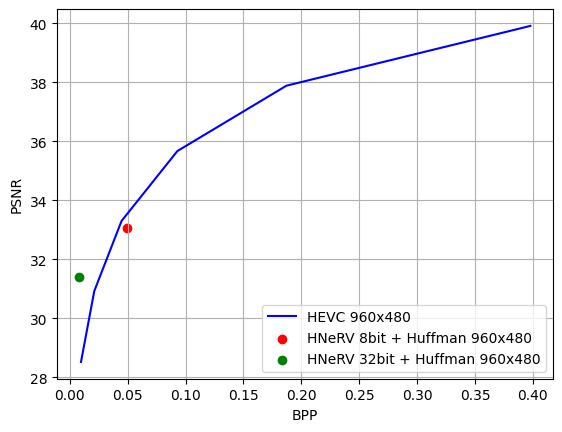

In [61]:
#Plot
plt.plot(df2_960_agg['BPP'],df2_960_agg['PSNR'],c='blue',label='HEVC 960x480')
plt.scatter(df1_agg.loc[df1_agg.index=='Vanilla 8bit']['BPP'],df1_agg.loc[df1_agg.index=='Vanilla 8bit']['Quant PSNR'],c='red',label='HNeRV 8bit + Huffman 960x480')
plt.scatter(df1_agg.loc[df1_agg.index=='Vanilla 32bit']['BPP'],df1_agg.loc[df1_agg.index=='Vanilla 32bit']['Quant PSNR'],c='green',label='HNeRV 32bit + Huffman 960x480')

plt.legend()
plt.grid(True)
plt.xlabel("BPP")
plt.ylabel("PSNR")

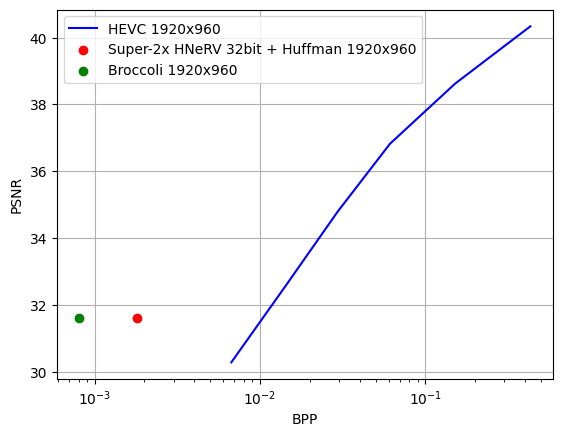

In [196]:
#Plot
plt.plot(df2_1080_agg['BPP'],df2_1080_agg['PSNR'],c='blue',label='HEVC 1920x960')
plt.scatter(df1_agg.loc[df1_agg.index=='2x 32bit']['BPP'],df1_agg.loc[df1_agg.index=='2x 32bit']['Quant PSNR'],c='red',label='Super-2x HNeRV 32bit + Huffman 1920x960')
plt.scatter(df1_agg.loc[df1_agg.index=='Broccoli']['BPP'],df1_agg.loc[df1_agg.index=='Broccoli']['Quant PSNR'],c='green',label='Broccoli 1920x960')

plt.legend()
plt.grid(True)
plt.xlabel("BPP")
plt.ylabel("PSNR")
plt.xscale('log')

Text(0, 0.5, 'PSNR')

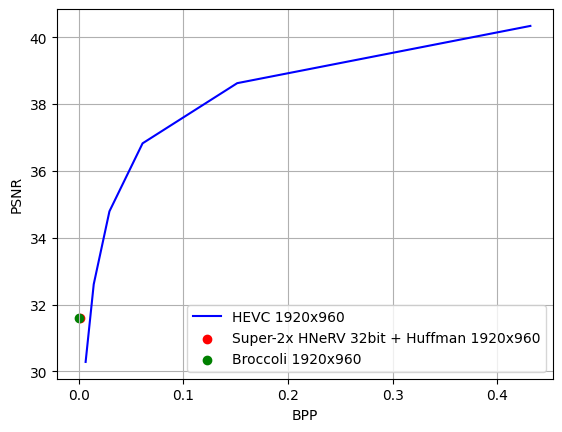

In [62]:
#Plot
plt.plot(df2_1080_agg['BPP'],df2_1080_agg['PSNR'],c='blue',label='HEVC 1920x960')
plt.scatter(df1_agg.loc[df1_agg.index=='2x 32bit']['BPP'],df1_agg.loc[df1_agg.index=='2x 32bit']['Quant PSNR'],c='red',label='Super-2x HNeRV 32bit + Huffman 1920x960')
plt.scatter(df1_agg.loc[df1_agg.index=='Broccoli']['BPP'],df1_agg.loc[df1_agg.index=='Broccoli']['Quant PSNR'],c='green',label='Broccoli 1920x960')

plt.legend()
plt.grid(True)
plt.xlabel("BPP")
plt.ylabel("PSNR")

### Select Out Fast Changing and Chaotic Videos

In [119]:
df1_vid = [i.split('_')[1] for i in df1.Vid.values]
df1['Video'] = df1_vid

In [120]:
df1

,Vid,Resolution,Train Epoch,BPP,BPS,Quant PSNR,Ori PSNR,Model,Video
0,8bit_SunBath_QTM8_QTE6,480_960,300,0.087020,2.004938e+06,31.514930,31.751402,Vanilla 8bit,SunBath
1,8bit_RaceNight_QTM8_QTE6,480_960,300,0.043188,9.950431e+05,27.013725,27.171285,Vanilla 8bit,RaceNight
2,8bit_FlowerKids_QTM8_QTE6,480_960,300,0.043122,9.935396e+05,27.342269,27.441277,Vanilla 8bit,FlowerKids
3,8bit_FlowerFocus_QTM8_QTE6,480_960,300,0.043090,9.927896e+05,38.363552,38.490876,Vanilla 8bit,FlowerFocus
4,8bit_RiverBank_QTM8_QTE6,480_960,300,0.043159,9.943802e+05,31.078864,31.143553,Vanilla 8bit,RiverBank
5,8bit_CityAlley_QTM8_QTE6,480_960,300,0.043084,9.926492e+05,40.910336,41.017326,Vanilla 8bit,CityAlley
6,8bit_YatchRide_QTM8_QTE6,480_960,300,0.043101,2.383313e+06,28.704297,28.780799,Vanilla 8bit,YatchRide
7,8bit_ShakeNDry_QTM8_QTE6,480_960,300,0.086940,4.807422e+06,34.338230,34.378609,Vanilla 8bit,ShakeNDry
8,8bit_Jockey_QTM8_QTE6,480_960,300,0.043168,2.387017e+06,30.331778,30.475479,Vanilla 8bit,Jockey
9,8bit_Bosphorus_QTM8_QTE6,480_960,300,0.043125,2.384664e+06,33.945489,34.019645,Vanilla 8bit,Bosphorus


In [121]:
#Select good videos for HNeRV
bad = ['2x_RaceNight_QTM32_QTE6','2x_FlowerKids_QTM32_QTE6','2x_ReadySteadyGo_QTM32_QTE6','2x_YatchRide_QTM32_QTE6','2x_RiverBank_QTM32_QTE6']
bad_cleaned = [i.split('_')[1] for i in bad]

df1_good = df1.loc[~df1.Video.isin(bad_cleaned)]

In [122]:
df1_good

,Vid,Resolution,Train Epoch,BPP,BPS,Quant PSNR,Ori PSNR,Model,Video
0,8bit_SunBath_QTM8_QTE6,480_960,300,0.087020,2.004938e+06,31.514930,31.751402,Vanilla 8bit,SunBath
3,8bit_FlowerFocus_QTM8_QTE6,480_960,300,0.043090,9.927896e+05,38.363552,38.490876,Vanilla 8bit,FlowerFocus
5,8bit_CityAlley_QTM8_QTE6,480_960,300,0.043084,9.926492e+05,40.910336,41.017326,Vanilla 8bit,CityAlley
7,8bit_ShakeNDry_QTM8_QTE6,480_960,300,0.086940,4.807422e+06,34.338230,34.378609,Vanilla 8bit,ShakeNDry
8,8bit_Jockey_QTM8_QTE6,480_960,300,0.043168,2.387017e+06,30.331778,30.475479,Vanilla 8bit,Jockey
9,8bit_Bosphorus_QTM8_QTE6,480_960,300,0.043125,2.384664e+06,33.945489,34.019645,Vanilla 8bit,Bosphorus
10,8bit_Beauty_QTM8_QTE6,480_960,300,0.043107,2.383630e+06,34.201208,34.291342,Vanilla 8bit,Beauty
12,8bit_Twilight_QTM8_QTE6,480_960,300,0.043091,9.928228e+05,40.722402,40.841009,Vanilla 8bit,Twilight
13,8bit_HoneyBee_QTM8_QTE6,480_960,300,0.043077,2.382012e+06,40.265718,40.353601,Vanilla 8bit,HoneyBee
0,vanilla_HoneyBee_QTM{qt_model}_QTE6,480_960,300,0.006469,3.577280e+05,26.570000,26.570000,Vanilla 32bit,HoneyBee


In [123]:
#Agg
df1_good_agg = df1_good.groupby("Model").mean()
df1_good_agg

,Train Epoch,BPP,BPS,Quant PSNR,Ori PSNR
Model,,,,,
2x 32bit,600.0,0.001929,3.121438e+05,34.398488,34.449022
Broccoli,600.0,0.000898,1.406039e+05,34.398488,34.449022
Vanilla 32bit,300.0,0.008934,3.589498e+05,34.662222,34.593333
Vanilla 8bit,300.0,0.052856,2.147549e+06,36.065960,36.179921


In [124]:
#Do the same for HEVC
df2_960_good_agg = hevc.loc[(hevc.Resolution=='960x540') & (~hevc.Video.isin(bad_cleaned))].groupby(['QP']).mean()
df2_1080_good_agg = hevc.loc[(hevc.Resolution=='1920x1080') & (~hevc.Video.isin(bad_cleaned))].groupby(['QP']).mean()

df2_960_good_agg

,PSNR,BPP
QP,,
17,40.043113,0.352445
22,38.194556,0.153158
27,36.157912,0.074479
32,33.912868,0.035021
37,31.614561,0.016161
42,29.251236,0.007363


In [125]:
df2_1080_good_agg

,PSNR,BPP
QP,,
17,40.354030,0.442015
22,38.764164,0.140740
27,37.149020,0.049828
32,35.298359,0.023375
37,33.262313,0.011372
42,31.008559,0.005210


In [198]:
df2_1080_good_agg

,PSNR,BPP
QP,,
17,40.354030,0.442015
22,38.764164,0.140740
27,37.149020,0.049828
32,35.298359,0.023375
37,33.262313,0.011372
42,31.008559,0.005210


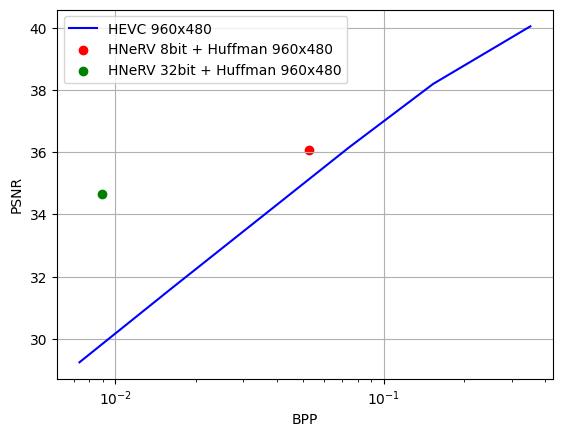

In [192]:
#Replot
plt.plot(df2_960_good_agg['BPP'],df2_960_good_agg['PSNR'],c='blue',label='HEVC 960x480')
plt.scatter(df1_good_agg.loc[df1_good_agg.index=='Vanilla 8bit']['BPP'],df1_good_agg.loc[df1_good_agg.index=='Vanilla 8bit']['Quant PSNR'],c='red',label='HNeRV 8bit + Huffman 960x480')
plt.scatter(df1_good_agg.loc[df1_good_agg.index=='Vanilla 32bit']['BPP'],df1_good_agg.loc[df1_good_agg.index=='Vanilla 32bit']['Quant PSNR'],c='green',label='HNeRV 32bit + Huffman 960x480')

plt.legend()
plt.grid(True)
plt.xlabel("BPP")
plt.ylabel("PSNR")
plt.xscale('log')

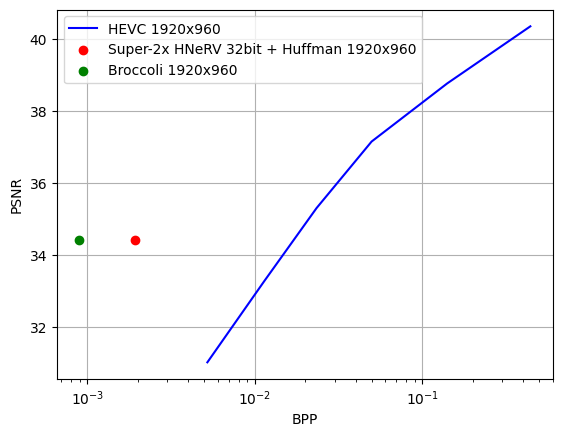

In [128]:
#Plot
plt.plot(df2_1080_good_agg['BPP'],df2_1080_good_agg['PSNR'],c='blue',label='HEVC 1920x960')
plt.scatter(df1_good_agg.loc[df1_good_agg.index=='2x 32bit']['BPP'],df1_good_agg.loc[df1_good_agg.index=='2x 32bit']['Quant PSNR'],c='red',label='Super-2x HNeRV 32bit + Huffman 1920x960')
plt.scatter(df1_good_agg.loc[df1_good_agg.index=='Broccoli']['BPP'],df1_good_agg.loc[df1_good_agg.index=='Broccoli']['Quant PSNR'],c='green',label='Broccoli 1920x960')

plt.legend()
plt.grid(True)
plt.xlabel("BPP")
plt.ylabel("PSNR")
plt.xscale('log')

In [132]:
#Create tables

##HNeRV
#No super res
df1_1_agg = df1_agg.loc[df1_agg.index.isin(['Vanilla 32bit','Vanilla 8bit'])]

#With super res
df1_2_agg = df1_agg.loc[~df1_agg.index.isin(['Vanilla 32bit','Vanilla 8bit'])]

In [156]:
#Clean
df1_1_agg = df1_1_agg[['Quant PSNR','BPP']]
df1_2_agg = df1_2_agg[['Quant PSNR','BPP']]

df1_1_agg.columns = ['PSNR','BPP']
df1_2_agg.columns = ['PSNR','BPP']

KeyError: "['Quant PSNR'] not in index"

In [140]:
#HEVC
df2_960_agg_reformed = df2_960_agg.copy()
df2_960_agg_reformed['QP'] = df2_960_agg_reformed.index
df2_960_agg_reformed.index = ['HEVC @ QP{}'.format(i) for i in df2_960_agg_reformed.index]

In [142]:
#HEVC
df2_1080_agg_reformed = df2_1080_agg.copy()
df2_1080_agg_reformed['QP'] = df2_1080_agg_reformed.index
df2_1080_agg_reformed.index = ['HEVC @ QP{}'.format(i) for i in df2_1080_agg_reformed.index]

In [ ]:
#Clean
df2_960_agg_reformed = df2_960_agg_reformed[['PSNR','BPP']]
df2_1080_agg_reformed = df2_1080_agg_reformed[['PSNR','BPP']]

In [185]:
df2_960_agg_reformed.mean() #avg value

PSNR    34.369404
BPP      0.125607
dtype: float64

In [186]:
df2_1080_agg_reformed.mean()

PSNR    35.578183
BPP      0.115823
dtype: float64

In [162]:
#Combine
comb_agg_960 = pd.concat([df1_1_agg,df2_960_agg_reformed])
comb_agg_960

,PSNR,BPP
Vanilla 32bit,31.416429,0.008421
Vanilla 8bit,33.068937,0.049385
HEVC @ QP17,39.917487,0.397785
HEVC @ QP22,37.889087,0.187117
HEVC @ QP27,35.673015,0.093010
HEVC @ QP32,33.298238,0.044746
HEVC @ QP37,30.920052,0.021217
HEVC @ QP42,28.518545,0.009769


In [190]:
(8.42e-3 - 9.77e-3) / 9.77e-3

-0.1381780962128965

In [163]:
#Combine
comb_agg_1080 = pd.concat([df1_2_agg,df2_1080_agg_reformed])
comb_agg_1080

,PSNR,BPP
2x 32bit,31.594854,0.001802
Broccoli,31.594854,0.000809
HEVC @ QP17,40.339535,0.431642
HEVC @ QP22,38.626199,0.151550
HEVC @ QP27,36.824919,0.061121
HEVC @ QP32,34.789130,0.029457
HEVC @ QP37,32.607298,0.014458
HEVC @ QP42,30.282018,0.006710


In [177]:
#Look at Broccoli vs equivalent
broccoli_vs = comb_agg_1080.loc[comb_agg_1080.index.isin(['Broccoli','HEVC @ QP37','HEVC @ QP42'])]
broccoli_vs

,PSNR,BPP
Broccoli,31.594854,0.000809
HEVC @ QP37,32.607298,0.014458
HEVC @ QP42,30.282018,0.006710


In [182]:
broccoli_vs.iloc[1:3] / broccoli_vs.iloc[0] #relative diff

,PSNR,BPP
HEVC @ QP37,1.032045,17.873071
HEVC @ QP42,0.958448,8.295134


In [183]:
broccoli_vs.iloc[1:3] - broccoli_vs.iloc[0] #relative diff

,PSNR,BPP
HEVC @ QP37,1.012444,0.013649
HEVC @ QP42,-1.312836,0.005901


In [103]:
Table for 
Broccoli vs HEVC individual
Broccoli vs HEVC agg

All variants vs HEVC individual
All variants vs HEVC agg

SyntaxError: invalid syntax (400516164.py, line 1)

array([[<AxesSubplot: title={'center': "('Ori PSNR',)"}>]], dtype=object)

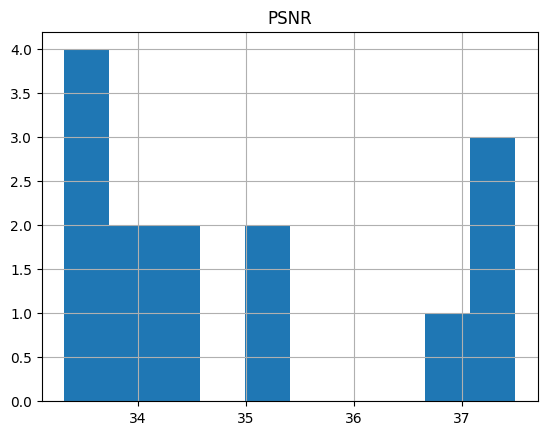

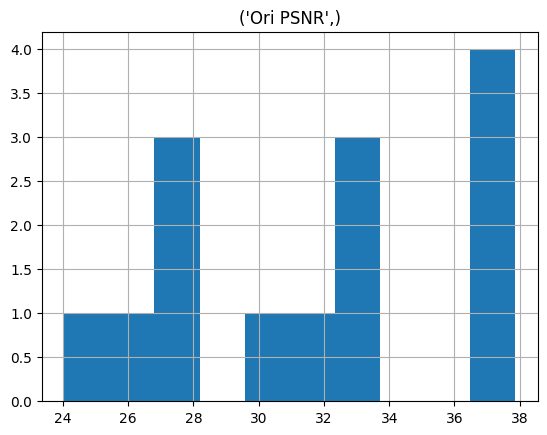

In [77]:
hevc.groupby('Video').mean().hist('PSNR')
f6_.hist('Ori PSNR')

**Note**: Broccoli would be good for landscape, slower moving shots (cityscape, twilight) or shots with fewer quick movements (beauty)

___
### Check Difference Between 24bit and 32bit quant resolution

In [6]:
bit32 = "/scratch/kl3866/IVP/HNeRV/batches/final/2x_1080_HNeRV_gamut/2x_HNeRV_gamut/2x_Beauty_QTM32_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M32_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1/quant_vid.pth"
bit24 = "/scratch/kl3866/IVP/HNeRV/batches/output/2x_24bit_gamut/2x_Beauty_QTM24_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M24_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1/quant_vid.pth"

In [9]:
import torch

#Read
b32 = torch.load(bit32,map_location=torch.device('cpu'))
b24 = torch.load(bit24,map_location=torch.device('cpu'))

In [56]:
#Extract
b32_embed = b32['embed']['quant'].ravel()
b24_embed = b24['embed']['quant'].ravel()

b32_model = [v['quant'].ravel() for k,v in b32['model'].items()]
b32_model = torch.cat(b32_model)

b24_model = [v['quant'].ravel() for k,v in b24['model'].items()]
b24_model = torch.cat(b24_model)

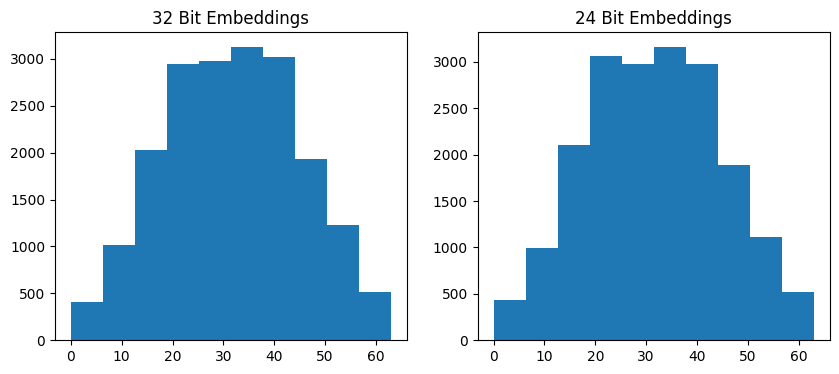

In [67]:
#Plot hist
fig,axs = plt.subplots(1,2,figsize=[10,4])

axs[0].hist(b32_embed)
axs[0].title.set_text('32 Bit Embeddings')
axs[1].hist(b24_embed)
axs[1].title.set_text('24 Bit Embeddings')

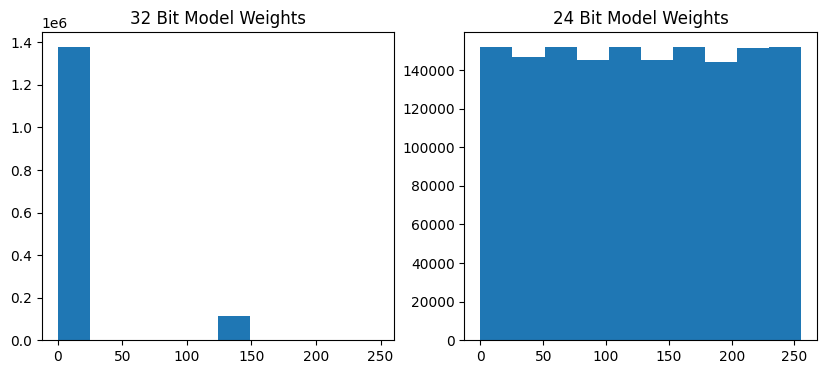

In [68]:
#Plot hist
fig,axs = plt.subplots(1,2,figsize=[10,4])

axs[0].hist(b32_model)
axs[0].title.set_text('32 Bit Model Weights')
axs[1].hist(b24_model)
axs[1].title.set_text('24 Bit Model Weights')

-----
### Draft

In [1]:
!python run_hnerv.py --data_path "/scratch/ar7996/ivp/uvgdataset/Beauty_3840x2160_120fps_420_8bit_YUV_RAW/Beauty_3840x2160_YUV_444_1920x1080_cropped_images/"  \
                      --batchSize 1 \
                      --vid 2x_Beauty_QTM24_QTE6 \
                      --outf batches/output/2x_24bit_gamut/ \
                      --conv_type convnext pshuffel \
                      --eval_only \
                      --act gelu \
                      --norm none  \
                      --crop_list 960_1920 \
                      --resize_list -1 \
                      --loss L2 \
                      --enc_strds 5 4 4 3 2 \
                      --enc_dim 64_16 \
                      --dec_strds 5 4 4 3 2 \
                      --ks 0_1_5 \
                      --reduce 1.2 \
                      --modelsize 1.5  \
                      --epochs 600 \
                      --eval_freq 50 \
                      --lower_width 12 \
                      --lr 0.001 \
                      --super \
                      --super_rate 2 \
                      --quant_model_bit 28 \
                      --quant_embed_bit 6 \
                      --hard_outf \
                      --dump_images 


init_method: tcp://127.0.0.1:15188
Namespace(data_path='/scratch/ar7996/ivp/uvgdataset/Beauty_3840x2160_120fps_420_8bit_YUV_RAW/Beauty_3840x2160_YUV_444_1920x1080_cropped_images/', vid='2x_Beauty_QTM24_QTE6', shuffle_data=False, data_split='1_1_1', crop_list='960_1920', resize_list='-1', embed='', ks='0_1_5', enc_strds=[5, 4, 4, 3, 2], enc_dim='64_16', modelsize=1.5, saturate_stages=-1, super=True, super_rate=2, fc_hw='9_16', reduce=1.2, lower_width=12, dec_strds=[5, 4, 4, 3, 2], num_blks='1_1', conv_type=['convnext', 'pshuffel'], norm='none', act='gelu', compression_method='huffman', workers=4, batchSize=1, start_epoch=-1, not_resume=False, epochs=600, block_params='1_1', lr=0.001, lr_type='cosine_0.1_1_0.1', loss='L2', out_bias='tanh', eval_only=True, eval_freq=50, quant_model_bit=28, quant_embed_bit=6, quant_axis=0, dump_images=True, dump_videos=False, eval_fps=False, encoder_file='', manualSeed=1, distributed=False, debug=False, print_freq=50, weight='None', overwrite=False, outf='